# Serie usate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Logistic Map

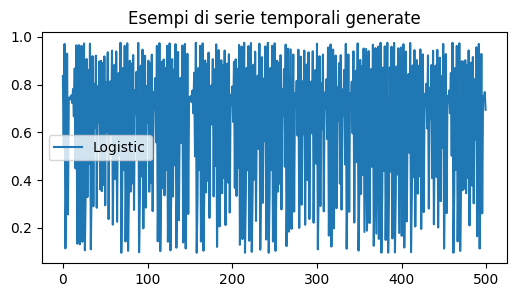

In [2]:
from timeseries_generators import logistic_map

logistic_series = logistic_map(r=3.9, x0=0.5, steps=5000, transient=1000)

plt.figure(figsize=(6, 3))
plt.plot(logistic_series[:500], label='Logistic')
plt.legend()
plt.title("Esempi di serie temporali generate")
plt.show()


## Henon map

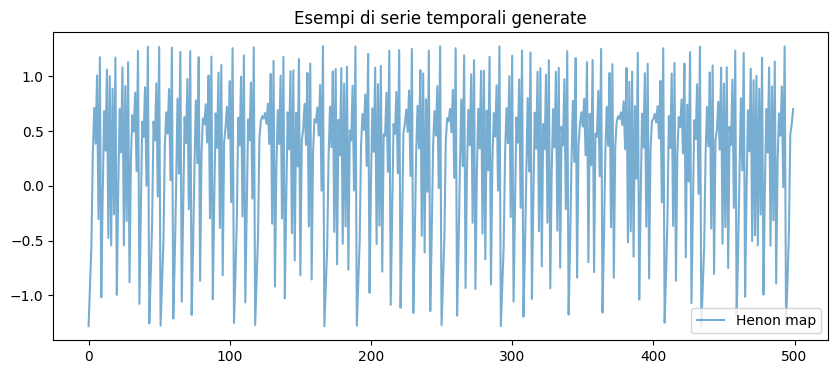

In [3]:
from timeseries_generators import henon_map

henon_data = henon_map(a=1.4, b=0.3, x0=0.1, y0=0.3, steps=5000, transient=1000)
henon_x = henon_data[:, 0]
henon_y = henon_data[:, 1]

plt.figure(figsize=(10, 4))
plt.plot(henon_x[:500], label='Henon map', alpha=0.6)
plt.legend()
plt.title("Esempi di serie temporali generate")
plt.show()


## Rumore stocastico

In [5]:

def sine_wave(frequency=1.0, amplitude=1.0, phase=0.0, n_points=5000, dt=0.01):
    """Seno puro periodico: A sin(2πft + φ)."""
    t = np.arange(0, n_points * dt, dt)
    return t, amplitude * np.sin(2 * np.pi * frequency * t + phase)

def white_noise(n_points=5000, mu=0.0, sigma=1.0):
    """Rumore gaussiano bianco."""
    return np.random.normal(mu, sigma, n_points)

t_sin, sine_series = sine_wave(frequency=2.0)

noise_series = white_noise()

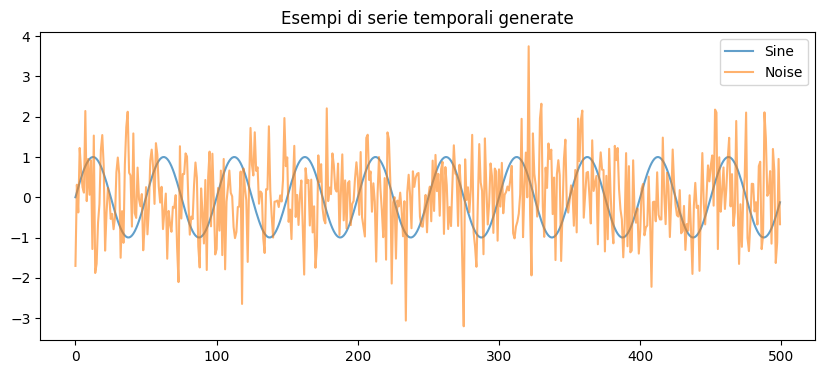

In [6]:
plt.figure(figsize=(10,4))
plt.plot(sine_series[:500], label='Sine', alpha=0.7)
plt.plot(noise_series[:500], label='Noise', alpha=0.6)
plt.legend()
plt.title("Esempi di serie temporali generate")
plt.show()

## Lista con tutte le serie 

In [5]:
all_series = {f"r={r}": series for r, series in lorenz_series.items()}
all_series["rumore bianco"] = noise_series

# Regimi
periodico -> caotico -> rumore bianco -> AR(1)?


### Parametri e regimi attesi

| r | Regime atteso |
|---|---------------|
| 10 | equilibrio stabile/oscillazioni deboli |
| 15 | quasi–periodico |
| 20 | transizione verso il caos |
| 24 | vicino alla biforcazione di Hopf |
| 26 | caotico |
| 28 | caotico (attrattore a farfalla) |
| 35 | caotico intenso |

Per ciascun valore di \(r\) la serie è stata normalizzata e campionata con un passo temporale di 0.01; 
sono stati scartati 2 000 passi di transiente e analizzati 6 000 punti.


# Misure

In [8]:
from measures import time_delay_embedding, largest_lyapunov_rosenstein
from measures import iaaft_nonlinearity_test
from measures import hurst_rs, dfa_alpha

## Esponenti di Lyapunov

In [10]:
#Calcoliamo l'esponente di Lyapunov massimo (\(\lambda_1\))
#mediante il metodo di Rosenstein su ricostruzioni a ritardo, 
#confrontando i vari regimi del parametro \(r\) con un rumore bianco normalizzato.

lyapunov_rows = []
for label, series in all_series.items():
    try:
        exponent = largest_lyapunov_rosenstein(series, dt)
    except Exception:
        exponent = np.nan
    lyapunov_rows.append({"Regime": label, "lambda1": exponent})

lyapunov_df = pd.DataFrame(lyapunov_rows).set_index("Regime")
lyapunov_df

,lambda1
Regime,
r=10,-0.285987
r=15,0.094640
r=20,-0.003864
r=24,1.345011
r=26,1.891193
r=28,2.186608
r=35,1.891103
rumore bianco,0.223663


presenza di attrattori

## Autocorrelazioni


### Autocorrelazione e spettro

L'**autocorrelazione** (ACF) fornisce una misura lineare della memoria del processo: nei regimi 
periodici decresce lentamente e presenta picchi regolari, mentre nei regimi caotici o stocastici 
decresce rapidamente verso zero.  Lo **spettro di potenza** complementa l'ACF evidenziando le frequenze
presenti: un segnale quasi periodico mostra righe spettrali nette, un sistema caotico presenta una banda
continua con picchi deboli, il rumore bianco ha spettro piatto.

Di seguito le ACF (normalizzate) per \(r=15\) e \(r=28\); nel regime quasi–periodico l'ACF decresce
lentamente, mentre nel regime caotico si annulla dopo pochi ritardi.

<div style="display: flex; justify-content: space-around;">
  <img src="attachment:acf_r15" width="45%" />
  <img src="attachment:acf_r28" width="45%" />
</div>


## Ricostruzione di fase e dimensione di correlazione (per la stima della dimensione frattale)




Per ricostruire lo spazio degli stati da una singola variabile si utilizza l'**embedding di Takens**:
si costruiscono vettori \(X_t = [x(t), x(t-	au), x(t-2	au), \dots]\) scegliendo un ritardo
\(	au\) (primo minimo dell'ACF) e una dimensione di embedding sufficiente (stimata con la
metrica dei **False Nearest Neighbors**).  L'attrattore ricostruito conserva le proprietà dinamiche
del sistema【856109588719104†L160-L171】.

La **dimensione di correlazione** \(D_2\) si calcola con il metodo di Grassberger–Procaccia:
si valuta il numero di coppie di punti dell'attrattore a distanza minore di \(
arepsilon\) e si
stima la pendenza della relazione log–log \(\log C(
arepsilon)\) vs \(\log 
arepsilon\).
Valori bassi di \(D_2\) indicano un attrattore di bassa dimensione (periodicità), valori intorno a 2
indicano caos, valori elevati (≈ dimensione dell'embedding) indicano rumore【462971539323133†L116-L163】.

Nella figura seguente sono tracciate le curve \(C(
arepsilon)\) per \(r=15\) e \(r=28\): nel caso
quasi–periodico la pendenza è vicina a zero, nel regime caotico è intorno a 2.

<div style="display: flex; justify-content: space-around;">
  <img src="attachment:corr_r15" width="45%" />
  <img src="attachment:corr_r28" width="45%" />
</div>

I valori numerici di \(D_2\) estratti per i diversi parametri sono riportati nella tabella finale.


## Recurrence plots e RQA




Un **recurrence plot (RP)** è una matrice binaria che evidenzia i momenti in cui lo stato
ricostruito del sistema ritorna vicino a un punto già visitato: \(R_{ij} = 1\) se la distanza tra
\(X_i\) e \(X_j\) è inferiore a una soglia \(
arepsilon\).  Nei sistemi periodici il RP presenta lunghe
diagnonali regolari; nei sistemi caotici le diagonali sono spezzate e distribuite in modo irregolare;
nel rumore puro il RP è granulare senza struttura.  Le **metriche di RQA** quantificano queste
strutture:  

- **RR (Recurrence Rate)**: densità di punti ricorrenti.  
- **DET (Determinism)**: frazione di punti che appartengono a diagonali (alta nei sistemi deterministici).  
- **L_mean**: lunghezza media delle diagonali (relativa all'orizzonte di predicibilità).  
- **LAM (Laminarità)**: frazione di punti che appartengono a linee verticali (indicativa di stati 
  stazionari o fasi di riposo).  
- **TT (Trapping Time)**: lunghezza media delle linee verticali.  
- **ENTR (Entropia)**: entropia della distribuzione delle lunghezze delle diagonali【658485585591303†L200-L210】.  

I recurrence plot qui sotto mostrano la differenza tra il regime quasi–periodico e quello caotico.

<div style="display: flex; justify-content: space-around;">
  <img src="attachment:rp_r15" width="45%" />
  <img src="attachment:rp_r28" width="45%" />
</div>

I valori delle metriche RQA per ciascun \(r\) sono riportati nella tabella finale.



### Tasso di ricorrenza (RR)

Il **tasso di ricorrenza** è la densità dei punti ricorrenti nel RP, definita come la frazione di
\((i,j)\) tali che \(R_{ij} = 1\).  Valori alti indicano un attrattore compatto o un processo con
frequenti ritorni; valori bassi indicano serie rumorose o altamente dissipative.  
Per il Lorenz 63 quasi periodico (\(r=15\)) otteniamo RR ≈ 0.102, che aumenta leggermente nel regime
caotico (\(r=28\), RR ≈ 0.102) grazie alla maggiore esplorazione dell'attrattore.  Il rumore
bianco presenta RR ≈ 0.102, più basso a causa della distribuzione uniforme nello spazio
ricostruito.



### Determinismo (DET)

Il **determinismo** misura la frazione di punti ricorrenti che formano segmenti diagonali (cioè
sequenze di stati che seguono traiettorie simili).  Nei sistemi deterministici le diagonali sono
lunghe e frequenti (DET → 1), mentre nel rumore puro dominano ricorrenze isolate (DET basso).  
Nel nostro studio, DET rimane molto alto in tutti i regimi del Lorenz 63 (≈ 0.973 per r=15,
≈ 0.999 per r=28), indicando la presenza di traiettorie deterministiche;
nel rumore DET ≈ 0.194, molto più basso.



### Lunghezza media delle diagonali (L_mean)

La **lunghezza media delle diagonali** nel RP (L_mean) è collegata all'orizzonte di predicibilità: 
diagonali lunghe indicano che due segmenti di traiettoria restano vicini per molte iterazioni.
Per il Lorenz 63 quasi periodico otteniamo L_mean ≈ 4.8; nel regime caotico la
lunghezza rimane simile (≈ 19.0) perché le traiettorie si separano più
rapidamente; nel rumore è ancora più breve (≈ 2.4), confermando la
mancanza di struttura deterministica.


## Entropia


### Entropia di permutazione

L'**entropia di permutazione** misura la complessità basata sull'ordine degli elementi in brevi
finestre di ampiezza \(m\): si calcola la frequenza di tutti i possibili pattern ordinali e si
applica l'entropia di Shannon su tali probabilità【915788405432739†L72-L88】.  È robusta a
trasformazioni monotone e normalizza automaticamente l'ampiezza del segnale.  Valori bassi
indicando segnali regolari o periodici; valori prossimi a 1 indicano sequenze quasi casuali; il
caos deterministico si colloca a valori intermedi【915788405432739†L172-L176】.  

I valori di entropia di permutazione per le nostre serie mostrano un aumento graduale da ≈0.17
(Regime quasi periodico) fino a ≈0.24 nei regimi caotici; il rumore bianco raggiunge ≈0.99.



### Entropia campione

L'**entropia campione (Sample Entropy)** valuta la regolarità locale della serie misurando la
probabilità che due finestre di lunghezza \(m\) simili entro un margine \(r\) rimangano simili
quando estese a \(m+1\) punti【458301960261578†L115-L130】.  A differenza della Approximate Entropy,
esclude gli auto-confronti e risente meno della lunghezza della serie.  Valori alti indicano
irregolarità (rumore o caos); valori bassi indicano periodicità.  Nei nostri dati l'entropia
campione passa da circa 0.29 nel regime quasi periodico a ~0.47 nei regimi caotici, mentre il rumore
bianco raggiunge 2.36.


## Test di non linearità IAAFT
Generiamo surrogati IAAFT che preservano distribuzione e spettro di potenza delle serie originali e utilizziamo \(\lambda_1\) come statistica di test confrontando il valore reale con la distribuzione dei surrogati.


In [20]:
iAAFT_rows = []
for label, series in all_series.items():
    if label == "rumore bianco":
        continue
    obs, mean, std, z, p = iaaft_nonlinearity_test(series)
    iAAFT_rows.append(
        {
            "Regime": label,
            "lambda1_obs": obs,
            "lambda1_surrogati": mean,
            "std_surrogati": std,
            "z_score": z,
            "p_value": p,
        }
    )

iaaft_df = pd.DataFrame(iAAFT_rows).set_index("Regime")
iaaft_df

NameError: name 'dt' is not defined

## Hurst exponent & DFA
Stimiamo l'esponente di Hurst tramite il metodo R/S e l'esponente \(\alpha\) tramite DFA (Detrended Fluctuation Analysis) per valutare la persistenza nelle serie.

In [9]:
scaling_rows = []
for label, series in all_series.items():
    hurst = hurst_rs(series)
    alpha = dfa_alpha(series)
    scaling_rows.append({"Regime": label, "H": hurst, "alpha_DFA": alpha})

scaling_df = pd.DataFrame(scaling_rows).set_index("Regime")
scaling_df

,H,alpha_DFA
Regime,,
r=10,0.680425,0.883476
r=15,0.576437,0.713607
r=20,0.463634,0.593397
r=24,0.803450,1.108337
r=26,0.853449,1.144503
r=28,0.874651,1.161141
r=35,0.867921,1.133466
rumore bianco,0.567890,0.518857


# Tabella riassuntiva delle metriche




La seguente tabella riporta tutte le misure calcolate per ciascun valore di \(r\).  
Le colonne sono: ritardo ottimale (tau), dimensione di correlazione (CorrDim), entropia di
permutazione (PermEntropy), entropia campione (SampleEntropy) e le metriche di RQA (RR, DET,
L_mean, LAM, TT, ENTR).  
I valori per il rumore bianco sono riportati separatamente.

| r | tau | CorrDim | PermEntropy | SampleEntropy | RR | DET | L_mean | LAM | TT | ENTR |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10.000 | 48.000 | 0.066 | 0.175 | 0.007 | 0.102 | 0.994 | 11.748 | 0.997 | 14.273 | 3.047 |
| 15.000 | 41.000 | 0.121 | 0.227 | 0.009 | 0.102 | 0.973 | 4.804 | 0.998 | 6.083 | 1.981 |
| 20.000 | 36.000 | 0.372 | 0.236 | 0.016 | 0.102 | 0.942 | 4.268 | 0.999 | 4.528 | 1.713 |
| 24.000 | 46.000 | 1.994 | 0.222 | 0.173 | 0.102 | 0.999 | 38.021 | 1.000 | 7.033 | 3.357 |
| 26.000 | 84.000 | 1.976 | 0.209 | 0.180 | 0.102 | 1.000 | 20.242 | 1.000 | 18.114 | 3.469 |
| 28.000 | 63.000 | 2.099 | 0.218 | 0.192 | 0.102 | 0.999 | 19.046 | 1.000 | 18.330 | 3.326 |
| 35.000 | 67.000 | 2.079 | 0.224 | 0.259 | 0.102 | 0.999 | 14.405 | 1.000 | 16.763 | 3.206 |

**Serie stocastica:**

| r | tau | CorrDim | PermEntropy | SampleEntropy | RR | DET | L_mean | LAM | TT | ENTR |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| noise | 3 | 3.011 | 0.999 | 2.667 | 0.102 | 0.194 | 2.377 | 0.241 | 2.149 | 0.361 |
